---
layout: chapter
title: Removing background waves with Harmonic Inversion
---

# Removing background waves with Harmonic Inversion

A first examination of the turbulence data reveals the presence of
background waves in the tank. These waves are remnants of the
filling process. Ideally the tank would have been allowed to settle
completely before an experiment was performed but logistical
contraints prevented this from occuring: the tank forms an efficient
wave guide and the time needed for wave decay would have been on the
order of one hour.

As it is, the waves form a strong and detectable signal in the data.
The challenge is to isolate and remove this signal. With the
assumption that the waves combine linearly with the gravity current
this can be done easily by subtracting the wave signal.


## Isolation of the signal

### Frame comparison

A first approximation to removing the background wave field is to
use the differnce between the current relative and lab relative
frames to attempt to isolate the wave field.

**Show work from last May with the summation and averaging of the
waves**

This is nearly satisfactory, but doesn't quite work.


### Harmonic Inversion

At first glance, this would appear to be exactly the problem that
the fourier transform solves. However, the fourier transform lacks
resolution for closely spaced frequencies:

In [5]:
# Plot a figure showing the fourier transform results

A more robust means of removing the background signal would be to
use our assumptions about the character of the signal in a more
formal way. *Given that* our background signal consists of a sum of
sinusoidal modes, we wish to determine the frequencies and
amplitudes of those mdoes - this is the problem of *harmonic
inversion*.

"Harmonic inversion of time signals," J.  Chem.  Phys.  107, 6756 (1997)

In [4]:
import gc_turbulence as g
%matplotlib inline

index = 'r14_01_14a'
cache_path = g.default_processed + index + '.hdf5'
r = g.ProcessedRun(cache_path=cache_path)

u_levels = np.linspace(*np.percentile(r.Uf[...], (1, 99)), num=100)

tf = r.Tf[:, 0, :]
zf = r.Zf[:, 0, :]

As we might expect, there are no waves in the mean front relative data:

<matplotlib.colorbar.Colorbar instance at 0x2b1304582248>

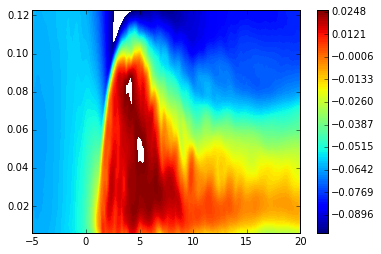

In [5]:
mean = np.mean(r.Uf[...], axis=1)
plt.contourf(tf, zf, mean, levels=u_levels)
plt.colorbar()

If we subtract the mean from the data and look at a single vertical
slice we can see waves:

<matplotlib.colorbar.Colorbar instance at 0x2b130b79fa28>

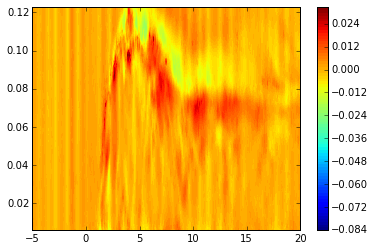

In [6]:
mean_subtracted = r.Uf[...] - mean[..., None, ...]
c = plt.contourf(tf, zf, mean_subtracted[:, 30, :], 100)
plt.colorbar()

<matplotlib.contour.QuadContourSet instance at 0x7ff1b8da7a28>

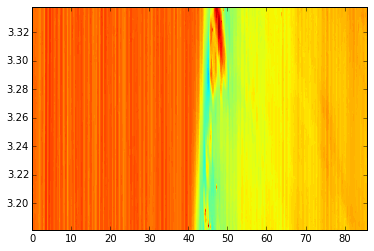

In [4]:
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]
plt.contourf(Te, r.X[0], mean_u, levels=u_levels)

### aside: Dynamic mode decomposition

In [ ]:
import sparse_dmd


snaps = sparse_dmd.to_snaps(mean_u)
dmd = sparse_dmd.DMD(snaps, dt=0.01)
dmd.compute()

In [47]:
spdmd = sparse_dmd.SparseDMD(dmd=dmd)
gamma = np.logspace(-6, -1, 20)
spdmd.compute_sparse(gamma)

splots = sparse_dmd.SparsePlots(spdmd)

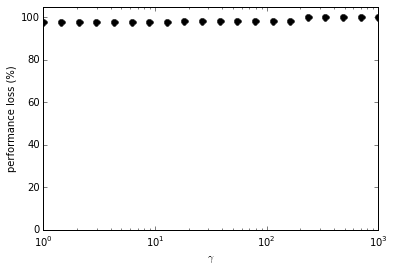

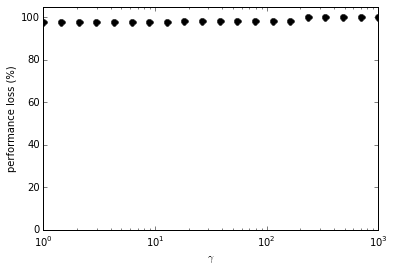

In [45]:
splots.performance_loss_gamma()

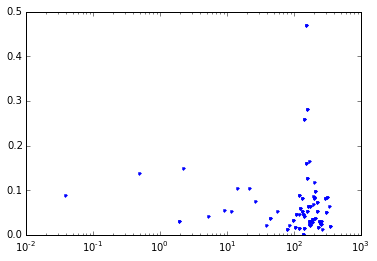

In [54]:
plt.semilogx(-dmd.frequencies.real, np.abs(dmd.amplitudes), '.')

A better way to get the signal:

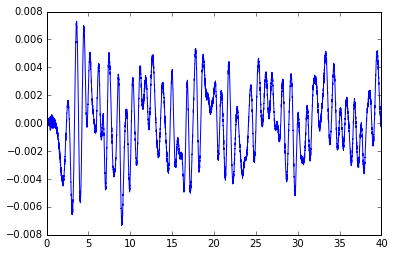

In [7]:
signal = np.mean(r.U[-10:, :, :], axis=0).mean(axis=0)[:4000]
t = r.T[0, 0, :4000]

plt.plot(t, signal)

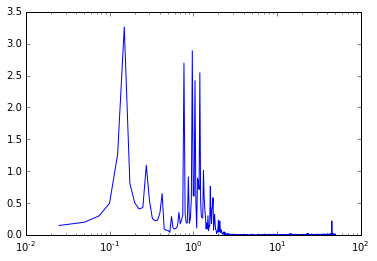

In [8]:
fft = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(signal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))

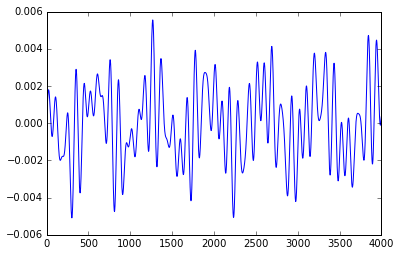

In [88]:
bad = np.abs(fft) > 2.5
plt.plot(np.fft.irfft(fft * bad))

/home/aaron/src/anaconda/envs/thesis/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


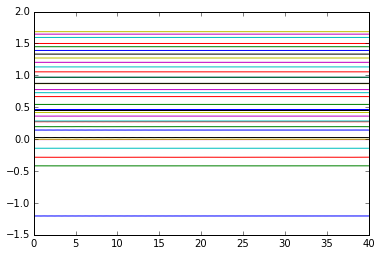

In [9]:
import harminv

inversion = harminv.Harminv(signal, fmin=0.01, fmax=4, dt=0.01)

for i, mode in enumerate(inversion.modes[inversion.Q > 100]):
    plt.plot(t, mode + inversion.freq[i])

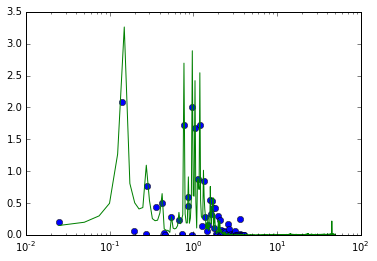

In [47]:
plt.semilogx(inversion.freq, 2000 * inversion.amplitude, 'o')

fft = np.fft.fft(signal)
freqs = np.fft.fftfreq(signal.size, d=0.01)
plt.semilogx(freqs, np.abs(fft))

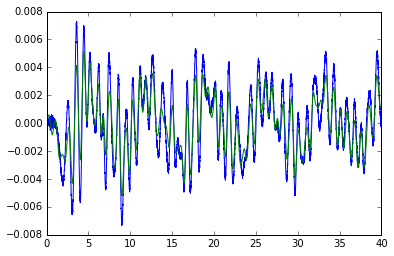

In [16]:
# compute the reconstructed signal
criterion = inversion.decay > 0
rsignal = inversion.modes[criterion].sum(axis=0)
plt.plot(t, signal)
plt.plot(t, rsignal)

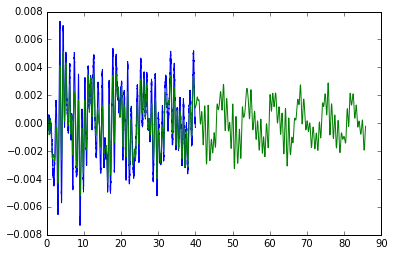

In [17]:
# compute the extended signal
te = r.T[0, 0, :]
emodes = inversion.compute_modes(te)
esignal = emodes[criterion].sum(axis=0)

plt.plot(t, signal)
plt.plot(te, esignal)

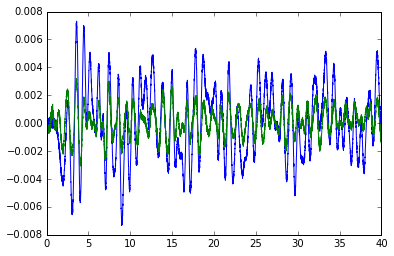

In [23]:
# now subtract from the data
mean_u = np.mean(r.U[-10:, :, :], axis=0)
Te = r.T[0, :, :]

plt.plot(t, signal)
plt.plot(t, signal - rsignal)

#plt.contourf(mean_u - esignal.real, 100)

In [24]:
ri = reduced_inversion = harminv.Harminv(signal - rsignal, fmin=0.01, fmax=4, dt=0.01)

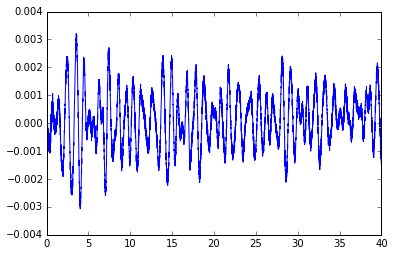

In [25]:
rrsignal = ri.modes[(ri.decay > 0) & (ri.Q > 100)].sum(axis=0)

plt.plot(t, signal - rsignal - rrsignal)
#plt.plot(t, rrsignal)

note: *(The other method to try is some form of autoregression, attempting to extend the signal.)*

Are we approaching the noise floor of the signal?

In [26]:
rri = harminv.Harminv(signal - rsignal - rrsignal, fmin=0.5, fmax=8, dt=0.01)

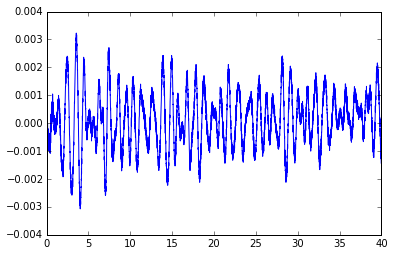

In [27]:
rrrsignal = rri.modes[(rri.decay > 0) & (rri.Q > 100)].sum(axis=0)

plt.plot(t, signal - rsignal - rrsignal - rrrsignal)

(-0.05, -0.07)

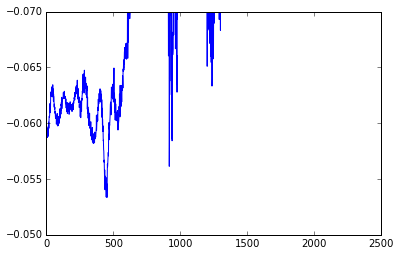

In [28]:
plt.plot(r.Uf[-10, 0, :4000])
plt.ylim(-0.05, -0.07)

### Application to the run

We wish to subtract this correction signal from our LAB relative data and then transform to the FRONT relative frame.

In [90]:
r.ft = r.ft[:]  # overcome a bug in the api
transformer = g.turbulence.FrontTransformer(r)

In [29]:
extended_modes = inversion.compute_modes(te)
reduced_extended_modes = reduced_inversion.compute_modes(te)

ersignal = extended_modes[inversion.decay > 0].sum(axis=0)
errsignal = reduced_extended_modes[reduced_inversion.decay > 0].sum(axis=0)

correction = ersignal.real + errsignal.real

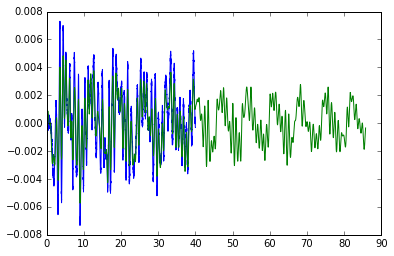

In [30]:
plt.plot(t, signal)
plt.plot(te, correction)

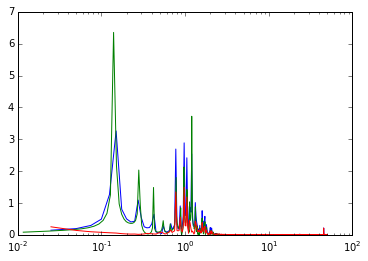

In [31]:
plt.semilogx(np.fft.rfftfreq(signal.size, d=0.01), np.abs(np.fft.rfft(signal)))
plt.semilogx(np.fft.rfftfreq(correction.size, d=0.01), np.abs(np.fft.rfft(correction)))
plt.semilogx(np.fft.rfftfreq(correction[:4000].size, d=0.01), np.abs(np.fft.rfft(signal - correction[:4000])))

In [32]:
corrected_data = r.U - correction

<matplotlib.contour.QuadContourSet instance at 0x7fbcc620f368>

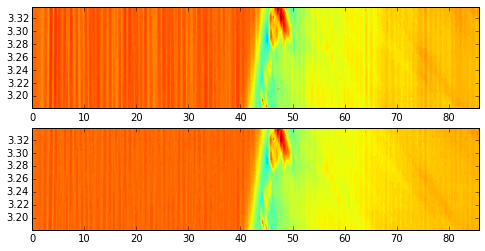

In [33]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 4))

axes[0].contourf(Te, r.X[0], mean_u, levels=u_levels)
axes[1].contourf(Te, r.X[0], mean_u - correction, levels=u_levels)

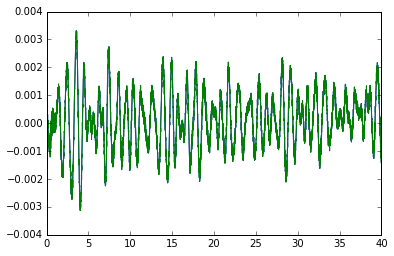

In [192]:
rcorr = np.mean(mean_u - correction, axis=0)
plt.plot(t, signal - correction[:4000])
plt.plot(t, rcorr[:4000])

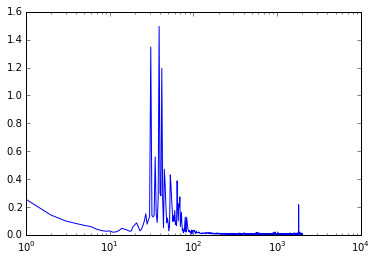

In [196]:
plt.semilogx(np.abs(np.fft.rfft(rcorr[:4000])))

In [35]:
inv = harminv.Harminv(signal - correction[:4000], fmin=0.7, fmax=1.5, dt=0.01)

(-0.002, 0.002)

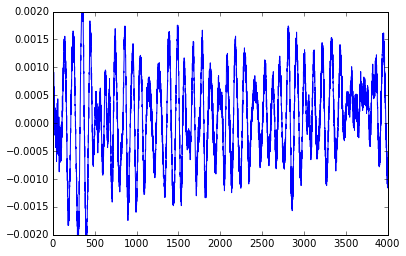

In [38]:
em = inv.compute_modes(te)
plt.plot(signal - correction[:4000] - em[inv.decay > 0].sum(axis=0)[:4000])

plt.xlim(0, 4000)
plt.ylim(-0.002, 0.002)

In [239]:
gobbler = g.turbulence.WaveGobbler(r)

In [27]:
waves = gobbler.get_waves(r.U)

<matplotlib.contour.QuadContourSet instance at 0x7f5bb279b248>

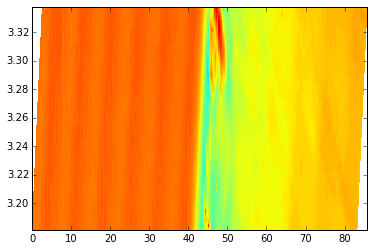

In [203]:
plt.contourf(Te, r.X[0], mean_u - waves[0], levels=u_levels)

Neither method entirely removes the waves. Perhaps a fusion will do the job?

In [204]:
iwaves = gobbler.get_waves(r.U - correction)

<matplotlib.colorbar.Colorbar instance at 0x7f5baa46d2d8>

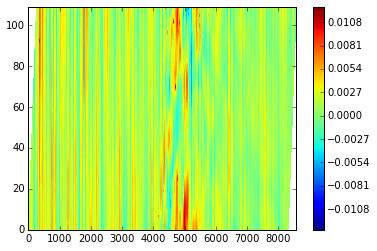

In [212]:
plt.contourf(waves[0], 100)
plt.colorbar()
#plt.contourf(Te, r.X[0], mean_u - iwaves[0], levels=u_levels)

In [209]:
cwaves = gobbler.get_clever_waves(r.U)

<matplotlib.colorbar.Colorbar instance at 0x7f5babeab830>

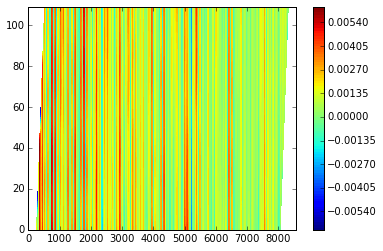

In [211]:
plt.contourf(cwaves[0], 100)
plt.colorbar()

In [28]:
icwaves = gobbler.get_clever_waves(corrected_data)

<matplotlib.contour.QuadContourSet instance at 0x7f8e77a752d8>

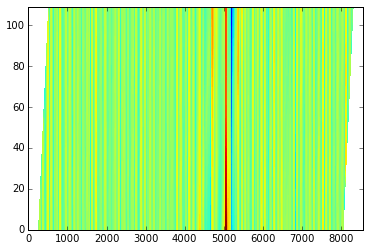

In [29]:
plt.contourf(icwaves[0], 100)

<matplotlib.contour.QuadContourSet instance at 0x7f8e6ed2cbd8>

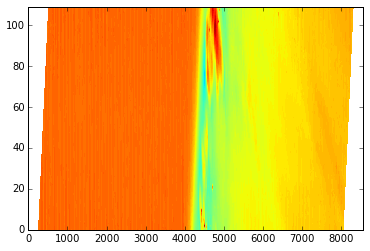

In [36]:
plt.contourf(mean_u - correction - icwaves[0], levels=u_levels)

In [89]:
residual = np.mean(mean_u - correction - icwaves[0], axis=0)[1000:4000]
#plt.plot(t, residual[:4000])
windowed_residual = residual * sig.kaiser(residual.size, 10)
plt.semilogx(np.abs(np.fft.rfft(windowed_residual)))
plt.semilogx(np.abs(np.fft.fft(signal[1000:4000])))

NameError: name 'icwaves' is not defined

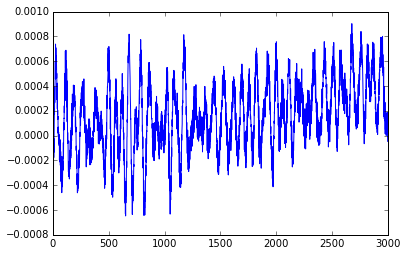

In [301]:
plt.plot(residual)

Another thing that we could attempt is just to flatten the fourier transform in the region of the bad stuff.

Take the fourier transform and find what is needed to flatten it. Then construct a longer signal using this bit.

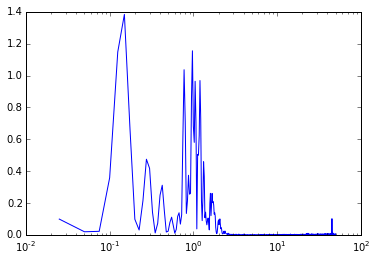

In [237]:
kaiser = sig.kaiser(signal.size, 10)
windowed_signal = signal * kaiser
rfs = np.fft.rfft(windowed_signal)
plt.semilogx(np.fft.rfftfreq(signal.size, d=0.01), np.abs(rfs))

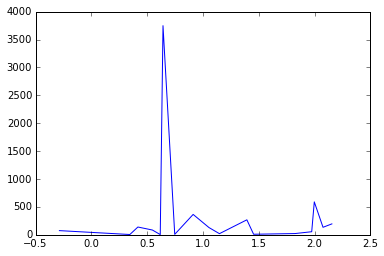

In [382]:
si = harminv.Harminv(signal, fmin=0.5, fmax=2, dt=0.01)
plt.plot(si.freq, np.abs(si.Q))

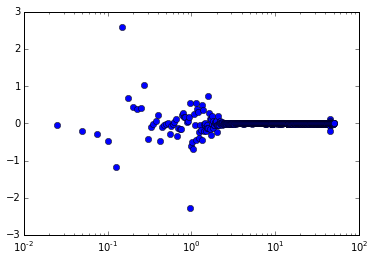

In [60]:
plt.semilogx(freqs, fft, 'o')

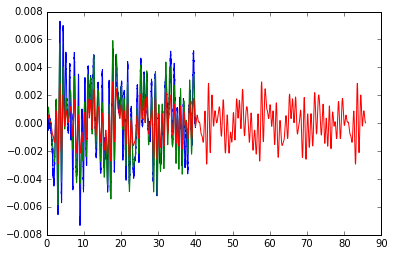

In [177]:
plt.plot(t, signal)
#plt.plot(t, c.sum(axis=0) / 2000)
plt.plot(t, 2 * c.sum(axis=0) / 4000)
plt.plot(te, ce.sum(axis=0) / 4000)
#plt.plot(t, signal - c.sum(axis=0) / 4000)

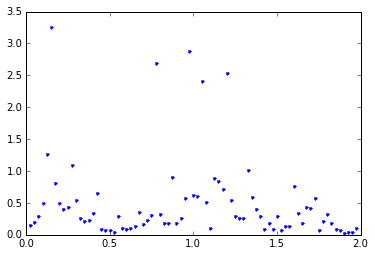

In [141]:
plt.plot(freqs[(freqs > 0) & (freqs < 2)], np.abs(fft[(freqs > 0) & (freqs < 2)]), '.')


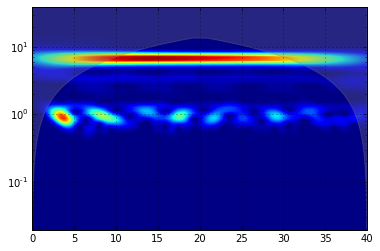

In [195]:
ax = wt.plot_power()

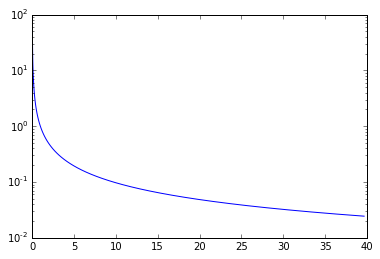

In [198]:
plt.semilogy(wt.scales, 1 / wt.fourier_periods)

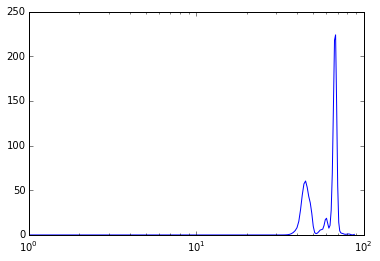

In [200]:
plt.semilogx(wt.global_wavelet_spectrum)

### Linear Predictive coding

In [41]:
# first detrend the signal
trend = np.polyfit(t, signal, 1)
dsignal = signal - (t * trend[0] + trend[1])

In [115]:
import spectrum

order = signal.size / 4
A, E, K = spectrum.arburg(dsignal, order=order)

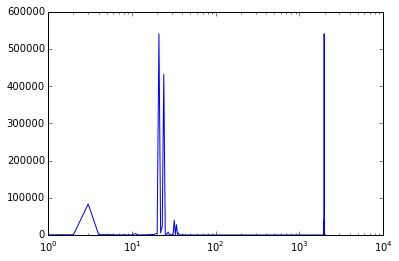

In [122]:
plt.semilogx(psd)

In [345]:
# now extend the data
y = np.zeros(te.size)
y[:4000] = dsignal

for i in range(4000, te.size):
    y[i] = np.sum(A[1:] * y[i-1:i-order:-1])

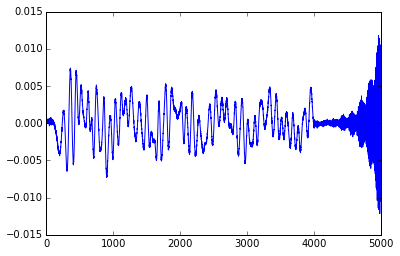

In [346]:
plt.plot(y[:5000])

In [373]:
# check our understanding by reconstructing the first part of the signal
y = np.zeros(t.size)
y[:order] = dsignal[:order]

for i in range(order, dsignal.size):
    y[i] = np.sum(A[1:] * y[i-order:i-1])

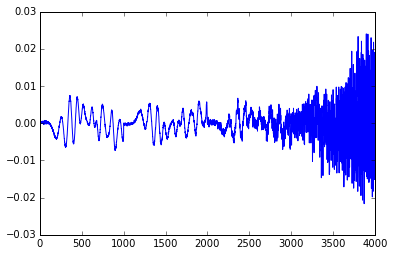

In [374]:
plt.plot(y)

<Container object of 3 artists>

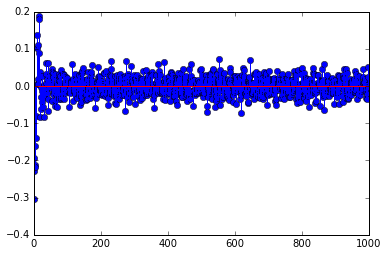

In [380]:
plt.stem(A)

### Statsmodels

In [62]:
import statsmodels.api as sm
import pandas

ewma = pandas.stats.moments.ewma

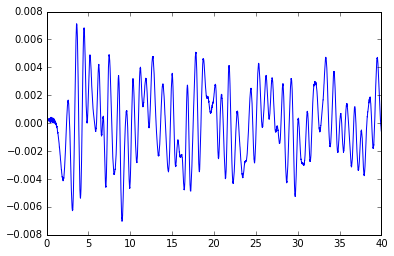

In [55]:
masignal = ewma(dsignal, com=2)
plt.plot(t, masignal)

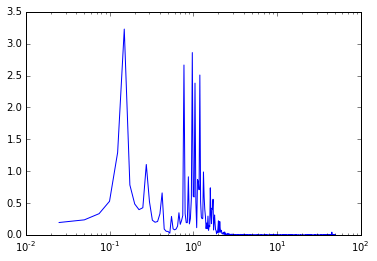

In [60]:
plt.semilogx(np.fft.rfftfreq(masignal.size, d=0.01), np.abs(np.fft.rfft(masignal)))

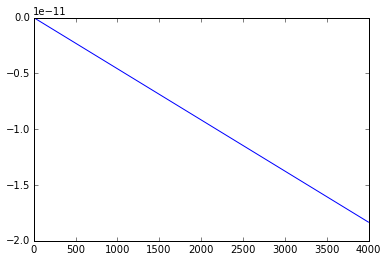

In [70]:
om = sm.OLS(dsignal, t)
olsres = om.fit()

plt.plot(olsres.predict(t))

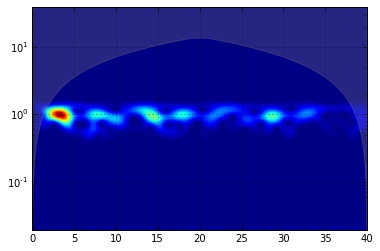

In [233]:
import wavelets

wt = wavelets.WaveletTransform(rcorr[:4000], unbias=True, dt=0.01)

wt.plot_power()

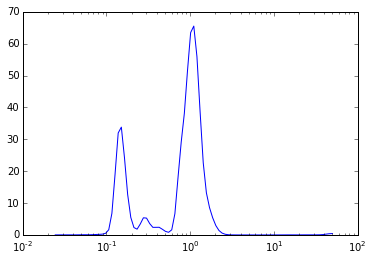

In [218]:
plt.semilogx(1 / wt.fourier_periods, wt.global_wavelet_spectrum)

In [141]:
def find_biggest_mode(signal):
    imax = np.argmax(np.abs(np.fft.rfft(signal)))
    amp = np.fft.rfft(signal)[imax]
    freq = np.fft.rfftfreq(signal.size, d=0.01)[imax]
    
    mode = 2 * amp * np.exp(2j * np.pi * freq * t) / signal.size
    return mode

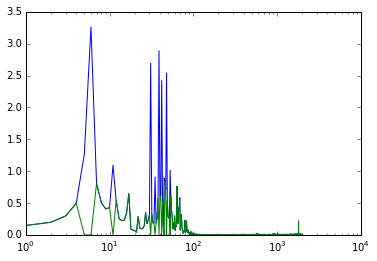

In [158]:
modes = []

s = signal.copy()
for i in range(10):
    mode = find_biggest_mode(s)
    s = s - mode
    modes.append(mode)
    
plt.semilogx(np.abs(np.fft.rfft(signal)))
plt.semilogx(np.abs(np.fft.rfft(s)))

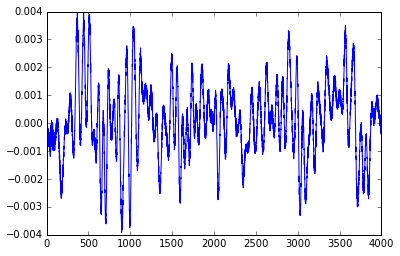

In [253]:
plt.plot(signal - sum(modes[:5]))

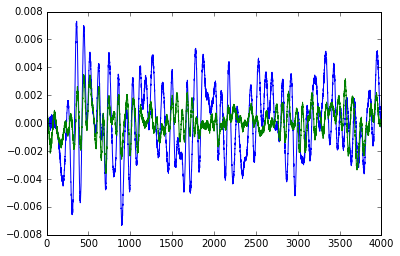

In [159]:
plt.plot(signal)
plt.plot(s)

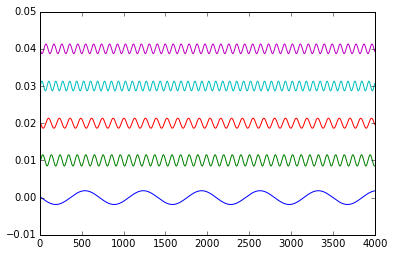

In [185]:
import scipy.optimize as opt

def find_biggest_mode(signal):
    imax = np.argmax(np.abs(np.fft.rfft(signal)))
    amp = np.fft.rfft(signal)[imax]
    freq = np.fft.rfftfreq(signal.size, d=0.01)[imax]
    return amp.real, freq, amp.imag

def f(t, amp, frequency, phase):
    return ((amp + 1j * phase) * np.exp(2j * np.pi * frequency * t)).real


s = signal.copy()

poppies = []
for i in range(5):
    popt, pcov = opt.curve_fit(f, t, s, p0=find_biggest_mode(s))
    s = s - f(t, *popt)
    poppies.append(popt)
    plt.plot(i / 100. + f(t, *popt))


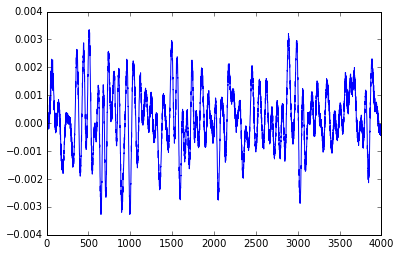

In [180]:
plt.plot(s)

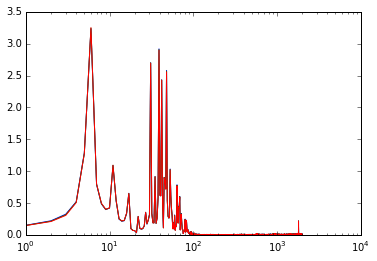

In [256]:
a = np.mean(r.U[-2:-1, :, :], axis=0).mean(axis=0)[:4000]
b = np.mean(r.U[-3:-2, :, :], axis=0).mean(axis=0)[:4000]
c = np.mean(r.U[-4:-3, :, :], axis=0).mean(axis=0)[:4000]

plt.semilogx(np.abs(np.fft.rfft(a)))
plt.semilogx(np.abs(np.fft.rfft(b)))
plt.semilogx(np.abs(np.fft.rfft(c)))

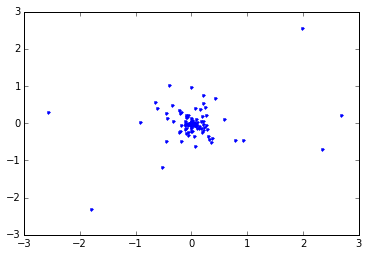

In [261]:
ft = np.fft.rfft(a)
plt.plot(ft.imag, ft.real, '.')